Internet can be used as one important source of information for machine learning algorithms. Web pages store diverse information about multiple domains. One critical problem is how to categorize this information.

Websites classification is performed by using ***NLP*** techniques that helps to generate words frequencies for each category and by calculating categories weights it is possible to predict categories for Websites.


---



This notebook is made for a challenge that Adot proposes, we are going to train a neural network to predict the categories of each given URL (even if this URL does not exist in reality, so we are not going to scrape the content of the pages which could give very good results) but we are going to use the URLs directly.

The Dataset is given by the company in the format of several parquet files and it contains 3 columns: 
*   **URLs (Uniform Resource Locator):** pages and web sites identifiers
*   **Targets:** the list of classes associated to the url ← what we want to predict
*   **Day:** day of the month




# Imports  

In [1]:
# Some important frameworks 
!python -m pip install dask[dataframe] --upgrade
!pip install fastparquet
!pip install pyenchant
!pip install transformers
!apt-get install libenchant1c2a
!apt-get install myspell-fr-fr
!pip install tldextract
!pip install scikit-multilearn
!pip install googledrivedownloader
!pip install wandb
!pip install numpy --upgrade 
# You may need to restart the runtime

     |████████████████████████████████| 118 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 1.5 MB 22.1 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
  Created wheel for thrift: filename=thrift-0.13.0-cp37-cp37m-linux_x86_64.whl size=348196 sha256=f34ceef975897466cc340ad15f128535081ed95a4f5e818578ef0c9a7c6ee705
  Stored in directory: /root/.cache/pip/wheels/79/35/5a/19f5dadf91f62bd783aaa8385f700de9bc14772e09ab0f006a
Successfully built thrift
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
     |████████████████████████████████| 636 kB 33.3 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 32.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Reading package lists... Done
Building d

In [1]:
import dask.dataframe as dd
from dask import delayed
from fastparquet import ParquetFile
import glob
import gc
from google.colab import drive
from google.colab import files
import json
import numpy as np
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
import tldextract
from urllib.parse import urlparse
from nltk.stem.snowball import FrenchStemmer
import re
import itertools
from setuptools.namespaces import flatten
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from skmultilearn.model_selection import IterativeStratification
import torch
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from torch.nn import BCEWithLogitsLoss, BCELoss
from transformers import AutoModelForSequenceClassification,AdamW
from tqdm import trange 
from google_drive_downloader import GoogleDriveDownloader as gdd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer ,AutoModelForSequenceClassification


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

# Loading data
The data are given in parquet format in several files, so we will read all the files and merge them into a dataframe.

In [3]:
def read_data_parquet(folder_path):
    """
    Returns a Dataframe that contains the contents of all the parquet files that are in the folder_path  
    """
    files = glob.glob(folder_path+'/*.parquet')
    @delayed
    def load_chunk(path):
        return ParquetFile(path).to_pandas()
    df = dd.from_delayed([load_chunk(f) for f in files])
    # computing the dataframe , removing the old index, creating a new index 
    pd_df=df.compute().reset_index().drop(columns='index')
    return pd_df

In [4]:
# Downloading data
gdd.download_file_from_google_drive(file_id='1q4EYndbegewI6wc59CiJSY6t9YitnHD4',
                                    dest_path='./data.zip',
                                    unzip=True)

Unzipping...Done.


In [5]:
folder_path = 'data'
df_data = read_data_parquet(folder_path)
df_data.head()

,url,target,day
0,https://www.seloger.com/annonces/locations/app...,"[378, 1178, 1710, 5529, 96]",16
1,https://www.gala.fr/l_actu/news_de_stars/charl...,"[507, 34, 1259, 184, 358]",1
2,https://www.cdiscount.com/juniors/plein-air/fu...,"[1404, 1403, 1586, 1191, 1398]",1
3,https://www.regal.fr/recettes/accompagnements/...,"[908, 122, 1515, 1556, 1542]",1
4,https://mobile-dictionary.reverso.net/francais...,"[692, 1265, 108, 1494, 474]",1


# Preproccessing Data

First of all, we must look for anomalies in the data (missing values, imbalance ..)

In [6]:
# looking for missing values
is_NaN = df_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_data[row_has_NaN]
print("Number of missing values in the dataset: ",len(rows_with_NaN))

Number of missing values in the dataset:  0


## Preproccessing labels

A URL can belong to several categories at the same time, so we're dealing with multilabel classification, therefore we're going to convert our label indices into one-hot representation where each input's set of labels is represented by a binary array.

We'll be writing our own LabelEncoder which is based on scikit-learn's implementation.

In [16]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    def load(self, fp):
        with open(fp, "r") as fp:
          self.class_to_index = json.load(fp=fp)["class_to_index"]
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

In [8]:
# One-hot encoding 
y = df_data['target']
# we're going to encode our output labels where we'll be assigning each tag a unique index.
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_labels = len(label_encoder)
print("Number of classes: ",num_labels)

Number of classes:  1903


In [9]:
# we create a new colomn in the dataframe with the one-hot encoding
df_data['tags'] = df_data['target'].apply(lambda x : list(flatten(label_encoder.encode([x]))))
y = label_encoder.encode(df_data['target'])
df_data.head()

,url,target,day,tags
0,https://www.seloger.com/annonces/locations/app...,"[378, 1178, 1710, 5529, 96]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,https://www.gala.fr/l_actu/news_de_stars/charl...,"[507, 34, 1259, 184, 358]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,https://www.cdiscount.com/juniors/plein-air/fu...,"[1404, 1403, 1586, 1191, 1398]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,https://www.regal.fr/recettes/accompagnements/...,"[908, 122, 1515, 1556, 1542]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,https://mobile-dictionary.reverso.net/francais...,"[692, 1265, 108, 1494, 474]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


minimum number of occurrences: 1
maximum number of occurrences: 4292
mean number of occurrences: 169.35417761429323


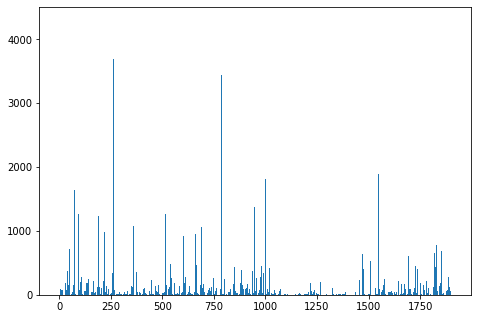

In [10]:
# Getting some statistics about labels 
count = y.sum(axis=0)
print('minimum number of occurrences:', min(count) )
print('maximum number of occurrences:', max(count) )
print('mean number of occurrences:', count.mean() )

# we plot the number of occurrences of each class
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(count)),count)
plt.show()

As we can see, there are about ten classes that are very common. We will eliminate them in the plot so that the distribution of the other classes is clear.

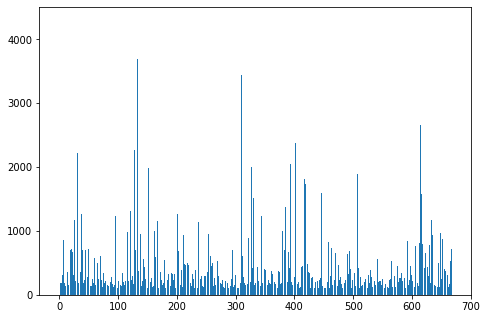

In [11]:
# we plot the number of occurrences of each class
sub_count = count[np.where(count>100)[0]]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(sub_count)),sub_count)
plt.show()

As we can see in the plot, there is a huge imbalance in the dataset.


In [12]:
print('number of label that appears just once on the hole dataset',len(np.where(count==1)[0]))

number of label that appears just once on the hole dataset 125


We are very limited by the lack of data for some classes, I opted for the deletion of classes that have very few examples in the dataset. We assume that it is better to have good performance using 80% of the base than poor performance on 100%. 

Logically thinking, to have 1903 categories of urls is a lot, we would like to have the real labels so that we can understand the categories (there may be subcategories of categories)

In [13]:
# Getting the indices of classes that appears less than min_occurence times in the dataset
min_occurence = 500
classes2delete = np.where(count<min_occurence)[0]
classes2delete

array([   0,    1,    2, ..., 1899, 1901, 1902])

In [14]:
# getting the list of real classes that we want to delete
label2delete = np.zeros(num_labels)
label2delete[classes2delete] = 1
label2delete=list(flatten(label_encoder.decode(np.array([label2delete]))))
print('the number of classes that appears less than '+str(min_occurence)+' times in the dataset: ',len(label2delete))
print('the new number of classes is: ',num_labels-len(label2delete))

the number of classes that appears less than 500 times in the dataset:  1759
the new number of classes is:  144


In [15]:
def substract(a,b):
  """
    return a list of element of a that doesn't belong to b
  """
  return [x for x in a if int(x) not in b]
# convert all the labels to integers
label2delete = [int(a) for a in label2delete ]
# deleting classes that appears less than 100 times
df_data['target'] = df_data['target'].apply(lambda x : substract(x ,label2delete))
df_data['target']

0               [378, 1710, 5529, 96]
1           [507, 34, 1259, 184, 358]
2                                  []
3              [908, 122, 1515, 1556]
4         [692, 1265, 108, 1494, 474]
                     ...             
67590                 [978, 582, 529]
67591                      [910, 122]
67592            [381, 925, 211, 930]
67593    [1048, 184, 1049, 1187, 358]
67594                      [61, 1686]
Name: target, Length: 67595, dtype: object

In [17]:
# Removing examples that doesn't belog to any classe 
initial_size = len(df_data['tags']) 
df_data = df_data[df_data['target'].map(len) != 0]
new_size = len(df_data['tags']) 
print('We will use '+str(round(new_size/initial_size,5)*100)+' % of the initial data set')

We will use 84.642 % of the initial data set


So we will use almost 85% of the dataset to train our model, which eliminates 1759 classes that occur less than 500 times in the dataset

In [18]:
# One-hot encoding 
y = df_data['target']
# we're going to encode our output labels where we'll be assigning each tag a unique index.
label_encoder_reduced = LabelEncoder()
label_encoder_reduced.fit(y)
num_labels = len(label_encoder_reduced)
print("Nombre de classes: ",num_labels)

Nombre de classes:  144


In [19]:
# we create a new colomn in the dataframe with the one-hot encoding
df_data['tags'] = df_data['target'].apply(lambda x : list(flatten(label_encoder_reduced.encode([x]))))
y = label_encoder_reduced.encode(df_data['target'])

minimum number of occurrences: 502
maximum number of occurrences: 4292
mean number of occurrences: 1174.3055555555557


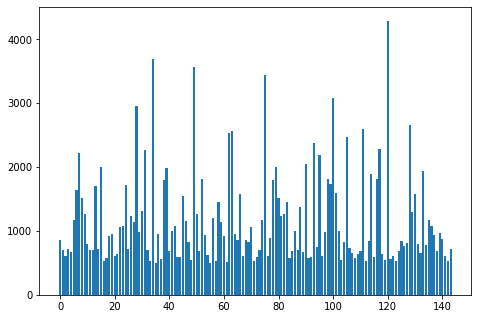

In [20]:
# Getting some statistics about labels 
count = y.sum(axis=0)
print('minimum number of occurrences:', min(count) )
print('maximum number of occurrences:', max(count) )
print('mean number of occurrences:', count.mean() )

# we plot the number of occurrences of each class
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(count)),count)
plt.show()

the dataset is still unbalanced, but still we have enough examples to train the model for each class.

Multilabel classification is different from Multiclass classification. In multiclas classification, each sample belongs to only one of the many classes. But in Multilabel classification, a single sample may belong to more than one class.

To deal with the Multilabel problem, we create a separate column for the labels obtained from Label Powerset transformation of the original labels.

To deal with the Multilabel problem, we create a separate column that contains the weight of each example (taking into account the classes to which it belongs)

In [21]:
# the weight of each class (the number of occurrences of the class / the total number of occurrences of the classes)
weights = np.round((count/count.sum())*10000,0)

def label_power(x,weights):
  """
    return the weight of an example from the dataset
    parameters:
      x : numpy array
        one-hot representation of tags
      weights : list
        list of all label's weight
  """
  return (np.array(x)*weights).sum()

label_power([1,0,0,1],[10,30,20,2])

12

In [22]:
#Applying Label Powerset Tranformation
df_data['powerlabel'] = df_data['tags'].apply(lambda x : label_power(x,weights))
df_data

,url,target,day,tags,powerlabel
0,https://www.seloger.com/annonces/locations/app...,"[378, 1710, 5529, 96]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",191.0
1,https://www.gala.fr/l_actu/news_de_stars/charl...,"[507, 34, 1259, 184, 358]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",541.0
3,https://www.regal.fr/recettes/accompagnements/...,"[908, 122, 1515, 1556]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",324.0
4,https://mobile-dictionary.reverso.net/francais...,"[692, 1265, 108, 1494, 474]",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",996.0
5,https://fr.shopping.rakuten.com/offer/buy/4045...,"[1143, 1146, 210, 531]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",362.0
...,...,...,...,...,...
67590,http://www.neonmag.fr/ou-le-tatouage-fait-il-l...,"[978, 582, 529]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116.0
67591,https://www.forums.supertoinette.com/recettes-...,"[910, 122]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",222.0
67592,http://m.jeuxvideo.com/forums/1-22728-2843992-...,"[381, 925, 211, 930]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",409.0
67593,https://variety.com/2019/film/news/jennifer-an...,"[1048, 184, 1049, 1187, 358]",16,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",503.0


## Preproccessing URLs

As we want to predict the categories from the URLs without scraping the content of the page, we have to extract the keywords from the URLs that can be useful to predict the categories.

First of all, if you look at some examples of the dataset, you can see that most of the URLs contain words in French (because they correspond to French pages) and sometimes some words in english.

In [23]:
# Some URLs from the dataset
df_data.url.values[:5]

array(['https://www.seloger.com/annonces/locations/appartement/levallois-perret-92/maurice-ravel/126841931.htm',
       'https://www.gala.fr/l_actu/news_de_stars/charlotte_gainsbourg_et_yvan_attal_in_love_et_assortis_a_los_angeles_367573',
       'https://www.regal.fr/recettes/accompagnements/panisses-10436',
       'https://mobile-dictionary.reverso.net/francais-definition/[vigoure',
       'https://fr.shopping.rakuten.com/offer/buy/4045108755/zero-gravity-rebirth-and-evolution.html'],
      dtype=object)

One of the most popular preprocessing for text is the removal of stopwords. But for URLs this pretreatment can change the meaning.

Here are just a few examples of how stop words can butcher URLs

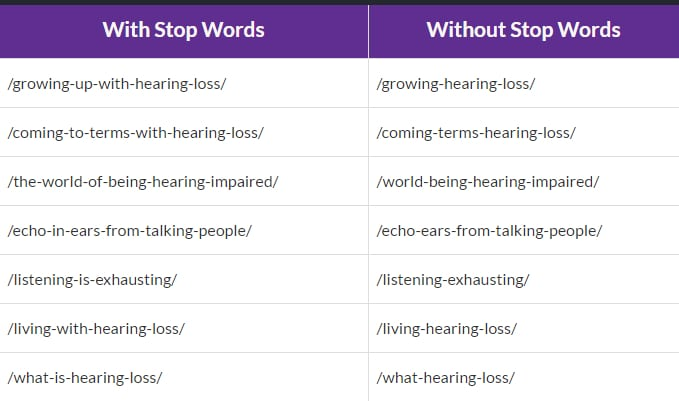

When you write for SEO, most experts suggest that it is better to remove SEO stop words from the URL. So we will try with and without the stop words removal

In [24]:
# Getting the stopwords list
final_stopwords_list = list(fr_stop) + list(en_stop)
len(final_stopwords_list)

926

In [25]:
# we can extend the stopwords list with some word related to URLs
final_stopwords_list += ['html','htm'] # .... to be added after

Another step can be stemming which consists in reducing a word in its "root" form. The purpose of stemming is to combine many variants of a word as a single word. For example, once you apply stemming to "Dogs" or "Dog", the resulting word is the same. This allows you to reduce the size of the vocabulary

In [26]:
# An example on Stemming
stemmer = SnowballStemmer(language='french')
stemmer.stem('contamination'), stemmer.stem('contaminer')

('contamin', 'contamin')

More concretely, we applied several steps as pre-processing that we can mention in the following order: 


1.   We extract from the URL the domain name, the path and the query if it exists (like in the search engine). 
2.   We split the (path + query) by the common separators in URLs (- _ % : , / . + =) and digits also.

3.  For each token obtained in the second step, we try to split it by uppercase letters (developers use to replace the space by an uppercase letter). For example: MultilabelClassification -> Multilabel Classification. 

4.  we convert each token into lowercase letters and we only take tokens that satisfy all the following conditions:

    *   Does not contain numbers.
    *   Its length is between 3 and 20 (if its length is too long it is most probably a hash and has no meaning).
    *   It does not belong to the stopwords list.
    *   One more condition (optional), if the word belongs to the French or English dictionary (it can help to remove the hashes which disturb the prediction, we will test the utility of that in prediction)

5.   we concatenate the domain name with the tokens (I did some experiments and I found that keeping the domain name gives better results)




In [27]:
# getting the french and english dictionnary from enchant library
#d_french = enchant.Dict('fr')
#d_english = d = enchant.Dict('en')

def splitAtUpperCase(s):
  """
    split the word s by uppercase letter
  """
  for i in range(len(s)-1)[::-1]:
      if s[i].isupper() and s[i+1].islower():
          s = s[:i]+' '+s[i:]
      if s[i].isupper() and s[i-1].islower():
          s = s[:i]+' '+s[i:]
  return s.split()

# an example of splitting by uppercase letters
splitAtUpperCase('FastANDFurious')

['Fast', 'AND', 'Furious']

In [28]:
def removal_condition(token ,stopwords, check_existence:bool) :
  """
    *Returns a boolean indicate if the token satisfy all the conditions or not*
    Parameters
    ----------
    token : str
        a word.
    stopwords : list of str
        a list of words that we want to remove.

    check_existence:bool 
        a boolean indicate if we want to check if the word exist in the dictionnary or not
    Returns
    -------
    bool
        the token satisfy all the conditions or not.
  """
  cond =  any(c.isdigit() for c in token) or len(token) <=2 or token in stopwords or len(token) >= 20 
  if check_existence and len(token) != 0 :
    cond = cond or not(d_english.check(token) or d_french.check(token)) 
  return not(cond)

In [29]:
def preprocess_url (url ,stopwords_list) :
  """
    *Process the url to make it ready to be used by the model*
    Parameters
    ----------
    url : str
        the url of a page.
    stopwords_list : list of str
        a list of words that we want to remove.
    Returns
    -------
    str
        processed url
  """

  # getting the domain name using tldextract library
  domain_name = tldextract.extract(url)[1]
  full_path = urlparse(url).path
  # getting the query if it exists otherwise it's empty
  query = urlparse(url).query
  # split of (path + query )
  splited_tokens = re.split('[- _ % : , / \. \+ = ]', full_path +' '+query)
  tokens = []
  # spliting by digits
  for token in splited_tokens : 
      tokens += re.split('\d+' , token)
  # spliting by uppercase letters
  tokens = list(flatten([splitAtUpperCase(s) for s in tokens]))
  # stemming , lowercasing , stopwords removal , and removing tokens with numbers 
  tokens = [ stemmer.stem(token.lower()) for token in tokens if removal_condition(token.lower() , stopwords_list,False) ]
  tokens = [token for token in tokens if removal_condition(token , stopwords_list,False)]
  # return unique elements
  # [domain_name] +
  final_sentence = list(dict.fromkeys([domain_name] + tokens))
  return " ".join(final_sentence)

In [30]:
# an example of preprocessing of a URL 
preprocess_url("https://github.com/ThinamXx/Fastai/blob/main/5.%20MultilabelClassification%20Regression/MultilabelClassification.ipynb",final_stopwords_list)

'github thinam fast blob main multilabel classif regress ipynb'

In [31]:
# preprocessing of all the URLs of the dataset
df_data['text_url'] = df_data['url'].apply(lambda x : preprocess_url(x , final_stopwords_list))
df_data.head()

,url,target,day,tags,powerlabel,text_url
0,https://www.seloger.com/annonces/locations/app...,"[378, 1710, 5529, 96]",16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",191.0,seloger annonc locat appart levallois perret m...
1,https://www.gala.fr/l_actu/news_de_stars/charl...,"[507, 34, 1259, 184, 358]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",541.0,gala actu new star charlott gainsbourg yvan at...
3,https://www.regal.fr/recettes/accompagnements/...,"[908, 122, 1515, 1556]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",324.0,regal recet accompagn
4,https://mobile-dictionary.reverso.net/francais...,"[692, 1265, 108, 1494, 474]",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",996.0,reverso franc definit [vigour
5,https://fr.shopping.rakuten.com/offer/buy/4045...,"[1143, 1146, 210, 531]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",362.0,rakuten offer buy zero gravity rebirth evolu


In [32]:
print('average sentence length: ', df_data.text_url.str.split().str.len().mean())
print('stdev sentence length: ', df_data.text_url.str.split().str.len().std())
print('maximum sentence length: ', df_data.text_url.str.split().str.len().max())

average sentence length:  6.395235431887301
stdev sentence length:  3.4228490630823956
maximum sentence length:  41


In [33]:
df_data = df_data[['text_url','tags','powerlabel']]
df_data

,text_url,tags,powerlabel
0,seloger annonc locat appart levallois perret m...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",191.0
1,gala actu new star charlott gainsbourg yvan at...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",541.0
3,regal recet accompagn,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",324.0
4,reverso franc definit [vigour,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",996.0
5,rakuten offer buy zero gravity rebirth evolu,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",362.0
...,...,...,...
67590,neonmag tatouag mal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116.0
67591,supertoinette recet pologn varie polonais,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",222.0
67592,jeuxvideo forum spoil aid mer trevor,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",409.0
67593,variety film new jennif aniston friend reunion...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",503.0


In [34]:
# Garbage collector
gc.collect()

73

## Split Data

For traditional multi-class tasks (each input has one label), we want to ensure that each data split has similar class distributions. However, our task is multi-label classification  (an input can have many labels) with imbalanced class distibution which complicates the stratification process.

we'll apply iterative stratification via the `skmultilearn library`, which essentially splits each input into subsets (where each label is considered individually) and then it distributes the samples starting with fewest "positive" samples and working up to the inputs that have the most labels.

In [35]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    return train_indices,test_indices

In [36]:
# Split sizes
train_size = 0.8
test_size = 0.2
# Split
train_indices,test_indices = iterative_train_test_split(df_data['text_url'].values,y , train_size=train_size)
#X_train, y_train = X[train_indices], y[train_indices]
#X_test, y_test = X[test_indices], y[test_indices]
df_data_train = df_data.iloc[train_indices]
df_data_test = df_data.iloc[test_indices]

In [37]:
print(len(df_data_train))

45729


 To deal with the imbalance, we do Random Oversampling of the training dataset on the Powerset labels.

In [38]:
powercount = {}
powerlabels = np.unique(df_data_train['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(df_data_train['powerlabel']==p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    temp_df = df_data_train.iloc[np.random.choice(np.where(df_data_train['powerlabel']==p)[0],size=gapnum)]
    df_data_train = df_data_train.append(temp_df,ignore_index=True)
df_data_train = df_data_train.sample(frac=1).reset_index(drop=True)  


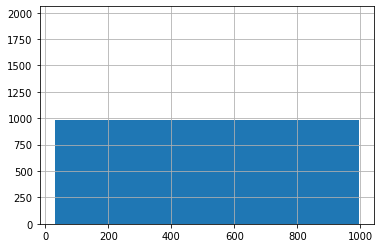

In [39]:
df_data_train['powerlabel'].hist(bins=np.unique(df_data_train['powerlabel']))

minimum number of occurrences in train set: 2688
maximum number of occurrences in train set: 114096
mean number of occurrences in train set: 16723.625


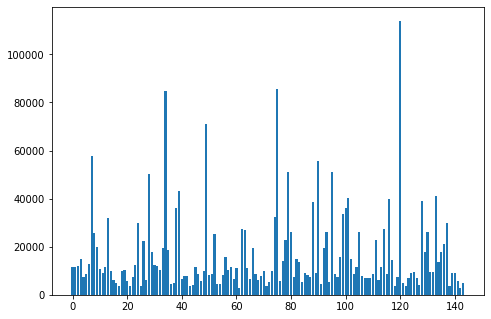

In [40]:
count = np.array([np.array(x) for x in df_data_train.tags]).sum(axis=0)
print('minimum number of occurrences in train set:', min(count) )
print('maximum number of occurrences in train set:', max(count) )
print('mean number of occurrences in train set:', count.mean() )

# we plot the number of occurrences of each class
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(range(len(count)),count)
gc.collect()
plt.show()

In [41]:
print('The number of rows in the new dataset: ',len(df_data_train))

The number of rows in the new dataset:  664137


In [42]:
X_train = df_data_train.text_url
y_train = df_data_train.tags
X_test = df_data_test.text_url
y_test = df_data_test.tags

## Model

As most of the words are in french ( because the sites are french), I will use a camemBert to predict the labels of each URL.

Like all transformers of the bert family, we have to go through the tokenizer first 

In [43]:
max_length = 30
tokenizer = AutoTokenizer.from_pretrained("camembert-base", do_lower_case=True) # tokenizer
encodings_train = tokenizer.batch_encode_plus(list(X_train),max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
encodings_test = tokenizer.batch_encode_plus(list(X_test),max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings_train.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])


In [44]:
# converting labels form list of list  to numpy array
y_train = np.array([np.array(x) for x in df_data_train.tags])
y_test = np.array([np.array(x) for x in df_data_test.tags])

In [45]:

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(encodings_train['input_ids']) # tokenized and encoded sentences
train_labels = torch.tensor(y_train)
train_masks = torch.tensor(encodings_train['attention_mask']) # attention masks

test_inputs = torch.tensor(encodings_test['input_ids']) # tokenized and encoded sentences
test_labels = torch.tensor(y_test)
test_masks = torch.tensor(encodings_test['attention_mask']) # attention masks


In [46]:
# Select a batch size for training. For fine-tuning with CamemBert, the authors recommend a batch size of 32, 48, or 128. We will use 48 here to avoid memory issues.
batch_size = 48

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [47]:
# Connecting to drive to save the dataloaders
drive.mount('/content/drive')
# saving data loaders
torch.save(test_dataloader,'drive/MyDrive/validation_data_loader')
torch.save(train_dataloader,'drive/MyDrive/train_data_loader')
# saving label_encoder
label_encoder_reduced.save('drive/MyDrive/label_encoder')
# saving count of each class ( that will be useful for training)
count.tofile('drive/MyDrive/count.dat')
# donwloading dataloaders on local
#files.download('validation_data_loader') 
#files.download('train_data_loader') 

Mounted at /content/drive


In [48]:
gc.collect()

297

Now that the data is ready for training and stored in drive we can start training

In [49]:
# Connecting to drive to save the dataloaders
#drive.mount('/content/drive')
# Getting data for training
count = np.fromfile('drive/MyDrive/count.dat', dtype=int)
test_dataloader = torch.load('drive/MyDrive/validation_data_loader')
train_dataloader = torch.load('drive/MyDrive/train_data_loader')
label_encoder = LabelEncoder()
label_encoder.load('drive/MyDrive/label_encoder')

In [50]:
num_labels = len(label_encoder)
print("Number of classes: ",num_labels)

Number of classes:  144


In [51]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = AutoModelForSequenceClassification.from_pretrained("camembert-base", num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [52]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [53]:
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

In [54]:
def calculate_pos_weights(class_counts,lenght):
    pos_weights = np.ones_like(class_counts)
    neg_counts = [lenght-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [55]:
len(train_dataloader) * 48

664176

In [57]:
import wandb
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

batch_size = 48
# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# trange i a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss(pos_weight=calculate_pos_weights(count,len(train_dataloader) * batch_size)).to(device)
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())   
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  wandb.log({'train-loss':tr_loss/nb_tr_steps})
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100
  wandb.log({'f1_accuracy':val_f1_accuracy})
  wandb.log({'flat_accuracy':val_flat_accuracy})

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.02552433798401657


Epoch:   5%|▌         | 1/20 [36:06<11:25:55, 2166.09s/it]

F1 Validation Accuracy:  60.884304673975755
Flat Validation Accuracy:  17.17892903787549
Train loss: 0.02462688981524576


Epoch:  10%|█         | 2/20 [1:12:10<10:49:41, 2165.64s/it]

F1 Validation Accuracy:  60.918056739315716
Flat Validation Accuracy:  18.450152372659993
Train loss: 0.024425066665211454


Epoch:  15%|█▌        | 3/20 [1:48:16<10:13:36, 2165.65s/it]

F1 Validation Accuracy:  61.145090044172626
Flat Validation Accuracy:  18.04962995211145
Train loss: 0.024207171010989417


Epoch:  20%|██        | 4/20 [2:24:26<9:37:50, 2166.90s/it] 

F1 Validation Accuracy:  61.35388002201431
Flat Validation Accuracy:  18.554636482368306
Train loss: 0.02372601963940082


Epoch:  25%|██▌       | 5/20 [3:00:35<9:01:53, 2167.56s/it]

F1 Validation Accuracy:  61.371583353853744
Flat Validation Accuracy:  18.850674793208533
Train loss: 0.02369147792883307


Epoch:  30%|███       | 6/20 [3:36:41<8:25:41, 2167.22s/it]

F1 Validation Accuracy:  61.21967116347135
Flat Validation Accuracy:  19.077057030909884
Train loss: 0.02329690662844545


Epoch:  35%|███▌      | 7/20 [4:12:44<7:49:16, 2165.90s/it]

F1 Validation Accuracy:  61.29036199039742
Flat Validation Accuracy:  19.08576404005224
Train loss: 0.023032074787526707


Epoch:  40%|████      | 8/20 [4:48:49<7:13:06, 2165.51s/it]

F1 Validation Accuracy:  61.74391397421217
Flat Validation Accuracy:  19.634305616020896
Train loss: 0.022905431143278747


Epoch:  45%|████▌     | 9/20 [5:24:55<6:37:03, 2165.81s/it]

F1 Validation Accuracy:  61.705670961521605
Flat Validation Accuracy:  20.330866347409664
Train loss: 0.022579865873557186


Epoch:  50%|█████     | 10/20 [6:01:01<6:00:57, 2165.80s/it]

F1 Validation Accuracy:  61.617256719877375
Flat Validation Accuracy:  19.35568132346539
Train loss: 0.022593517093746913


Epoch:  55%|█████▌    | 11/20 [6:37:07<5:24:53, 2165.97s/it]

F1 Validation Accuracy:  61.57504303565459
Flat Validation Accuracy:  19.44275141488899
Train loss: 0.023065116417195393


Epoch:  60%|██████    | 12/20 [7:13:13<4:48:46, 2165.83s/it]

F1 Validation Accuracy:  61.27691165553081
Flat Validation Accuracy:  19.79973878972573


In [62]:
torch.save(model, 'drive/MyDrive/camemBert_model_URLs')

Optimizing threshold value for micro F1 score !! 